In [41]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

try:
    from models.rc_2r2c import RC2R2C, RC2R2CParams
    from ocp.costs import evaluate_fixed_u_cost, OCPWeights
except ModuleNotFoundError:
    ROOT = Path.cwd()
    SRC = ROOT / "src"
    if SRC.exists():
        sys.path.insert(0, str(SRC))
        from models.rc_2r2c import RC2R2C, RC2R2CParams
        from ocp.costs import evaluate_fixed_u_cost, OCPWeights
    else:
        raise

print("✅ Imports OK")

✅ Imports OK


In [42]:
# 🔧 Parameters
import numpy as np

params = RC2R2CParams(
    C_air=1.2e6,   # J/K
    C_mass=9e6,    # J/K
    R_am=0.004,    # K/W
    R_ao=0.006,    # K/W
    dt=300.0       # 10 min steps
)
model = RC2R2C(params)

# Scenario
T_out = 283.15  # 10 °C (Kelvin)
T_sp  = 294.15  # 21 °C (Kelvin)
x0    = np.array([T_out + 2.0, T_out + 2.0])
N     = 2016  # 6 hours horizon (36 × 10 min)

# OCP weights
weights = OCPWeights(Q=1.0, R=1e-6)

print(f"dt = {params.dt} s, horizon = {N} steps (~{N*params.dt/3600:.1f} h)")


dt = 300.0 s, horizon = 2016 steps (~168.0 h)


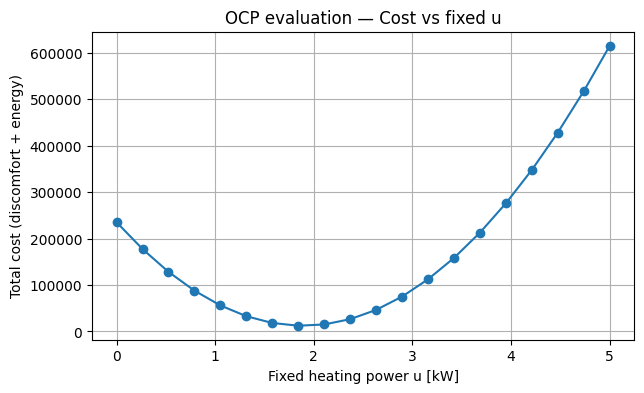

Best u ≈ 1.84 kW, total cost = 12291.96


In [43]:
# 🔎 Sweep fixed u values and compute costs

u_min, u_max, num = 0.0, 5000.0, 20  # W
u_grid = np.linspace(u_min, u_max, num)
costs = []
best = (None, float("inf"), None)

for u in u_grid:
    c, log = evaluate_fixed_u_cost(model, x0, u, T_out, T_sp, N, weights)
    costs.append(c)
    if c < best[1]:
        best = (u, c, log)

plt.figure(figsize=(7,4))
plt.plot(u_grid/1000.0, costs, marker="o")
plt.xlabel("Fixed heating power u [kW]")
plt.ylabel("Total cost (discomfort + energy)")
plt.title("OCP evaluation — Cost vs fixed u")
plt.grid(True)
plt.show()

print(f"Best u ≈ {best[0]/1000:.2f} kW, total cost = {best[1]:.2f}")


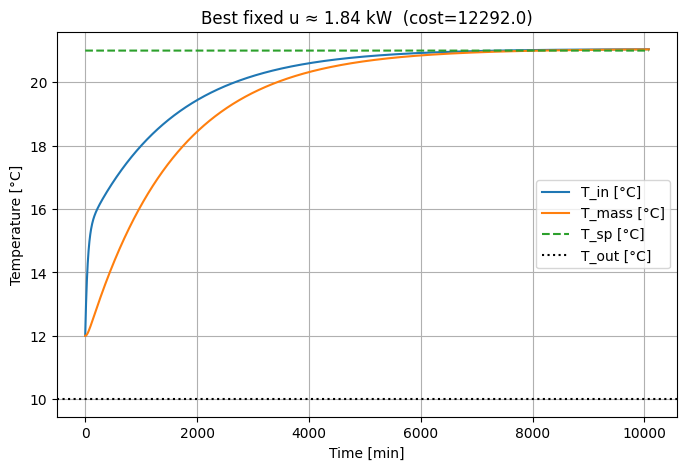

In [44]:
# 📈 Plot the best trajectory
best_u, best_cost, best_log = best
t_minutes = np.arange(N+1) * (params.dt/60.0)

plt.figure(figsize=(8,5))
plt.plot(t_minutes, best_log["T_in"]-273.15, label="T_in [°C]")
plt.plot(t_minutes, best_log["T_mass"]-273.15, label="T_mass [°C]")
plt.plot(t_minutes, best_log["T_sp"]-273.15, "--", label="T_sp [°C]")
plt.axhline(T_out-273.15, color="k", linestyle=":", label="T_out [°C]")
plt.xlabel("Time [min]")
plt.ylabel("Temperature [°C]")
plt.title(f"Best fixed u ≈ {best_u/1000:.2f} kW  (cost={best_cost:.1f})")
plt.legend()
plt.grid(True)
plt.show()


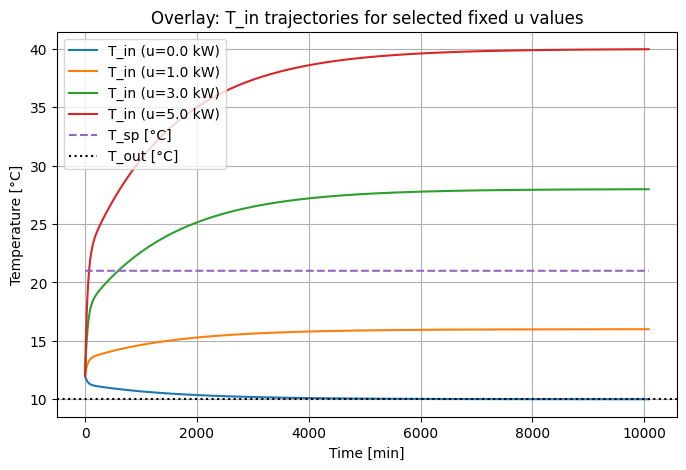

In [45]:
# 🖼️ Overlay trajectories for a few u values
subset = [0.0, 1000.0, 3000.0, 5000.0]
plt.figure(figsize=(8,5))
for u in subset:
    _, log = evaluate_fixed_u_cost(model, x0, u, T_out, T_sp, N, weights)
    plt.plot(t_minutes, log["T_in"]-273.15, label=f"T_in (u={u/1000:.1f} kW)")

plt.plot(t_minutes, best_log["T_sp"]-273.15, "--", label="T_sp [°C]")
plt.axhline(T_out-273.15, color="k", linestyle=":", label="T_out [°C]")
plt.xlabel("Time [min]")
plt.ylabel("Temperature [°C]")
plt.title("Overlay: T_in trajectories for selected fixed u values")
plt.legend()
plt.grid(True)
plt.show()
